# Q.4

### (GMM EM) Generate Figure 9.8 using the Old Faithful.

### Importing Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, pi, exp, log
from scipy import linalg
import math
%matplotlib inline

### Loading the old faithful dataset

In [6]:
df = pd.read_csv("faithful.csv")
df.drop(df.columns[0], axis="columns", inplace=True)
# df.head()

### Converting the dataset to numpy

In [7]:
dataset_np = df.to_numpy()
dataset_np[:, 1] = dataset_np[:, 1] / 10

### Plot the dataset

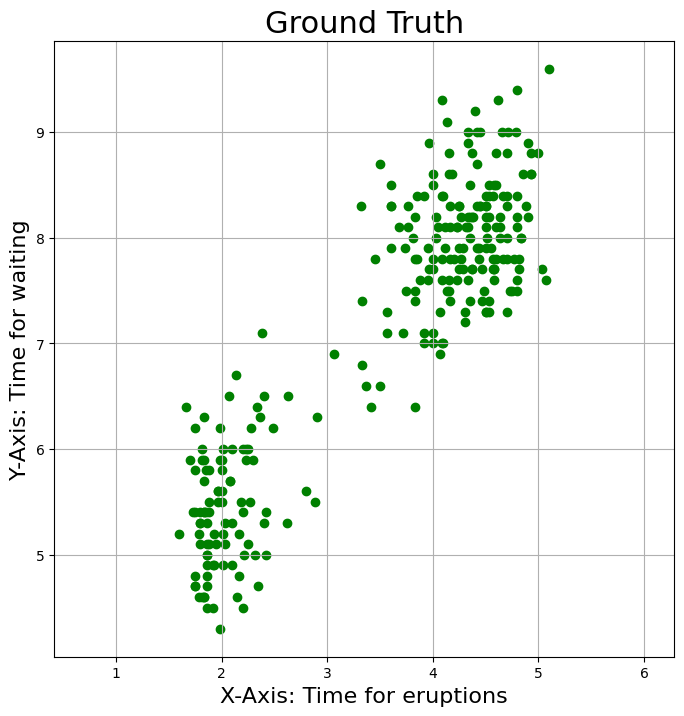

In [8]:
# Define figure size
plt.figure(figsize=(8, 8))
# Extract data from numpy array
y = dataset_np[:, 0]  # Column 0 of the array
x = dataset_np[:, 1]  # Column 1 of the array
# Create scatter plot with green markers
plt.scatter(y, x, marker='o', color='green')
# Set x and y axis to be equal in scale
plt.axis('equal')
# Add x and y axis labels with fontsize 16
plt.xlabel('X-Axis: Time for eruptions', fontsize=16)
plt.ylabel('Y-Axis: Time for waiting', fontsize=16)
# Add title with fontsize 22
plt.title('Ground Truth', fontsize=22)
# Add grid to the plot
plt.grid()
# Show the plot
plt.show()

### Standarding dataset

In [9]:
df = (df - df.mean()) / df.std()

### FORMULAS IN EM ALGORITHM FOR GMM:-

### Density function for multivariate normal distribution:

$${\displaystyle p_{\mathbf {k} }(x|\theta_k)={\frac {\exp \left(-{\frac {1}{2}}({\mathbf {x} }-{\boldsymbol {\mu_k }})^{\mathrm {T} }{\boldsymbol {\Sigma_k }}^{-1}({\mathbf {x} }-{\boldsymbol {\mu_k }})\right)}{\sqrt {(2\pi )^{d}|{\boldsymbol {\Sigma_k }}|}}}}$$

## E step:
Computing the responsibilities using the current parameter values

$$\large{\gamma(z_{nk}) = \frac{\pi_k N (x_n | \mu_k, \sigma_k)}{\sum\limits_{j=1}^k \pi_j N (x_n | \mu_j, \Sigma_j)}}$$

## M step:
Re-estimating the parameters using the current responsibilities

$$\large{\mu_k^{new} = \frac{1}{N_k} \sum \limits_{n=1}^N \gamma(z_{nk})x_n}$$

$$\large{\sigma_k^{new} = \frac{1}{N_k} \sum \limits_{n=1}^N \gamma(z_{nk}) (x_n - \mu_k^{new}) (x_n - \mu_k^{new})^{T}} $$

$$\large{\pi_k^{new} = \frac{N_k}{N}}$$

where,  
$$\large{N_k = \sum \limits_{n=1}^N \gamma(z_{nk})}$$

## Log Likelihood Function:
$$\large{ln \hspace{1mm} p(X|\mu, \Sigma, \pi) = \sum \limits_{n=1}^N ln \Bigg\{\sum \limits_{k=1}^K \pi_k N(x_n|\mu_k, \Sigma_k)\Bigg\}}$$

# EM Algorithm for Gaussian Mixture Model

### EM Class

In [10]:
class ExpectationMaximization:
    def __init__(self):
        # list of means for each Gaussian distribution
        self.means_list = None
        # list of covariance matrices for each Gaussian distribution
        self.sigma_list = None
        # list of mixing weight coefficients for each Gaussian distribution
        self.pi_list = None
        # number of Gaussian distributions
        self.K = None
        # threshold for convergence
        self.threshold = None
        # input data
        self.data = None
        # maximum number of iterations
        self.maxIter = None
        # current iteration
        self.iter = None
        # log likelihood values
        self.log_likelihood = None
        self.iteration_information = {'means_list': [], 'sigma_list': [],
                              'pi_list': [], 'log_likelihood': []}



    # Function for the formula of Gaussian Pdf

    def gaussian_pdf(self, X, Mu, Sigma):
        return (2 * math.pi) ** (-X.shape[0] / 2) * (np.linalg.det(Sigma) ** -0.5) * np.exp(-0.5 * np.dot(np.dot((X - Mu), np.linalg.inv(Sigma)), (X - Mu).T))




    def fit(self, X, K, maxIter=100, threshold=1e-5):

        # define initial parameters
        self.K = K                            # Number of clusters
        self.data = X                         # Input data
        self.maxIter = maxIter                # Maximum number of iterations
        self.threshold = threshold            # Convergence threshold
        self.iter = 0                         # Iteration counter
        self.log_likelihood = []              # Log likelihood values
        self.means_list = np.array([[-3, 3], [3, -3]])  # Means of each cluster
        self.sigma_list = np.random.rand(self.K, X.shape[1], X.shape[1])
        self.pi_list = np.random.rand(self.K)
        self.pi_list = self.pi_list / np.sum(self.pi_list)

        # initalise sigma to ones
        for i in range(self.K):
            self.sigma_list[i] = np.identity(X.shape[1])

        #***************************#
        # Running Main EM Algorithm
        #***************************#

        # Loop until maximum number of iterations is reached
        while self.iter < self.maxIter:
            print(f"\rCurrent Iteration Number till convergence: {self.iter}", end="") # Print iteration number to show progress
            self.iter += 1      # Increment iteration counter

            #***************************#
            # update parameters
            # ***************************#
            new_means_list = np.array([self.update_mu_k(k) for k in range(self.K)])
            new_sigma_list = np.array([self.update_sigma_k(k)
                                    for k in range(self.K)])
            new_pi_list = np.array([self.update_pi_k(k) for k in range(self.K)])

        
            # update means_list
            for k in range(self.K):
                # Update the mean of the current cluster
                new_means_list[k] = self.update_mu_k(k)
            # update sigma_list
            for k in range(self.K):
                # Update the covariance matrix of the current cluster
                new_sigma_list[k] = self.update_sigma_k(k)
            # update pis_list
            for k in range(self.K):
                # Update the prior probability of the current cluster
                new_pi_list[k] = self.update_pi_k(k)

            # update parameters
            self.means_list = new_means_list
            self.sigma_list = new_sigma_list
            self.pi_list = new_pi_list

            # update log likelihood
            # Append the log likelihood value of the current iteration
            self.log_likelihood.append(self.calculate_log_likelihood())

            #*************************#
            # save iteration data
            #*************************#

            # Append the means to the iteration data dictionary
            self.iteration_information['means_list'].append(self.means_list)
            # Append the covariance matrices to the iteration data dictionary
            self.iteration_information['sigma_list'].append(self.sigma_list)
            # Append the prior probabilities to the iteration data dictionary
            self.iteration_information['pi_list'].append(self.pi_list)
            # Append the log likelihood value of the current iteration to the iteration data dictionary
            self.iteration_information['log_likelihood'].append(self.log_likelihood[-1])
            #--------------------------------------#
            # CHECK CONVERGENCE
            if self.iter > 1:      # Check if more than one iteration has been completed
                if np.abs(self.log_likelihood[-1] - self.log_likelihood[-2]) < self.threshold:
                    break
            # --------------------------------------#



    # Updates the mean of the kth Gaussian distribution.

    def update_mu_k(self, k):
        # Initialize a new mean vector with all zeros
        new_mean = np.zeros(self.data.shape[1])
        # For each data point in the dataset
        for i in range(self.data.shape[0]):
            # Update the new mean by adding the weighted contribution of the ith data point
            new_mean += self.gamma_nk(i, k) * self.data[i]
        new_mean /= self.N_k(k)
        # Return the updated mean
        return new_mean



    # Updates the sigma of the kth Gaussian distribution.
    def update_sigma_k(self, k):
        new_sigma = np.zeros((self.data.shape[1], self.data.shape[1]))
        for i in range(self.data.shape[0]):
            # Compute the responsibility of the ith data point for the kth Gaussian
            gamma = self.gamma_nk(i, k)
            # Get the ith data point
            x = self.data[i]
            # Update the covariance matrix by adding the weighted outer product of (x-Mu)
            # where Mu is the mean of the kth Gaussian and x is the ith data point
            new_sigma += gamma * \
                np.outer((x - self.means_list[k]), (x - self.means_list[k]))
            # Ensure the covariance matrix is symmetric
            assert new_sigma[0][1] == new_sigma[1][0]
        new_sigma /= self.N_k(k)
        # Return the updated covariance matrix
        return new_sigma


    # uses the N_k function, which calculates the number of data points belonging to class k
    # gives the updated probability of class k, which can be used to calculate the posterior probabilities of each class given the data.

    def update_pi_k(self, k):
        return self.N_k(k) / self.data.shape[0]

    def gamma_nk(self, n, k):
        num_term = self.pi_list[k] * self.gaussian_pdf(
            self.data[n], self.means_list[k], self.sigma_list[k])
        den_term = np.sum(np.array([self.pi_list[i] * self.gaussian_pdf(
            self.data[n], self.means_list[i], self.sigma_list[i]) for i in range(self.K)]))
        return num_term / den_term

    def N_k(self, k):
        return np.sum(np.array([self.gamma_nk(n, k) for n in range(self.data.shape[0])]))

    # Function which returns the total log likelihood of the data given the current parameters
    def calculate_log_likelihood(self):
        return np.sum(np.array([np.log(np.sum(np.array([self.pi_list[i] * self.gaussian_pdf(self.data[n], self.means_list[i], self.sigma_list[i]) for i in range(self.K)]))) for n in range(self.data.shape[0])]))


In [11]:
em = ExpectationMaximization()  
em.fit(df.values, 2, maxIter=1000, threshold=1e-5)

Current Iteration Number till convergence: 34

### Variables represent the Mus, Sigmas, and mixing coefficients i.e Pis estimated during each iteration of the EM algorithm.


In [12]:
Mus = em.iteration_information['means_list']
Sigmas = em.iteration_information['sigma_list']
Pis = em.iteration_information['pi_list']

### Initialize variables to store probabilities and colors for each data point

In [13]:
probabilities = np.zeros((df.shape[0], em.K))
# A matrix to store colors for each data point.
color_list = np.zeros((df.shape[0], 3))
for i in range(df.shape[0]):
    for k in range(em.K):  # Iterate over each cluster.
        # Calculate the probability that the data point belongs to the current cluster
        probabilities[i, k] = em.pi_list[k] * em.gaussian_pdf(df.values[i], em.means_list[k], em.sigma_list[k])
    # Normalize the probabilities so that they sum to 1.
    probabilities[i] = probabilities[i] / np.sum(probabilities[i])
    # Calculate the color of the data point based on the probabilities.
    # The color will be a blend of red and blue, where the red value represents the probability of belonging to cluster 1
    # and the blue value represents the probability of belonging to cluster 2.
    color_list[i] = np.array([probabilities[i, 0], 0, probabilities[i, 1]])


### Scatter plot of the data points, where the color of each point is determined by its probability of belonging to each cluster.


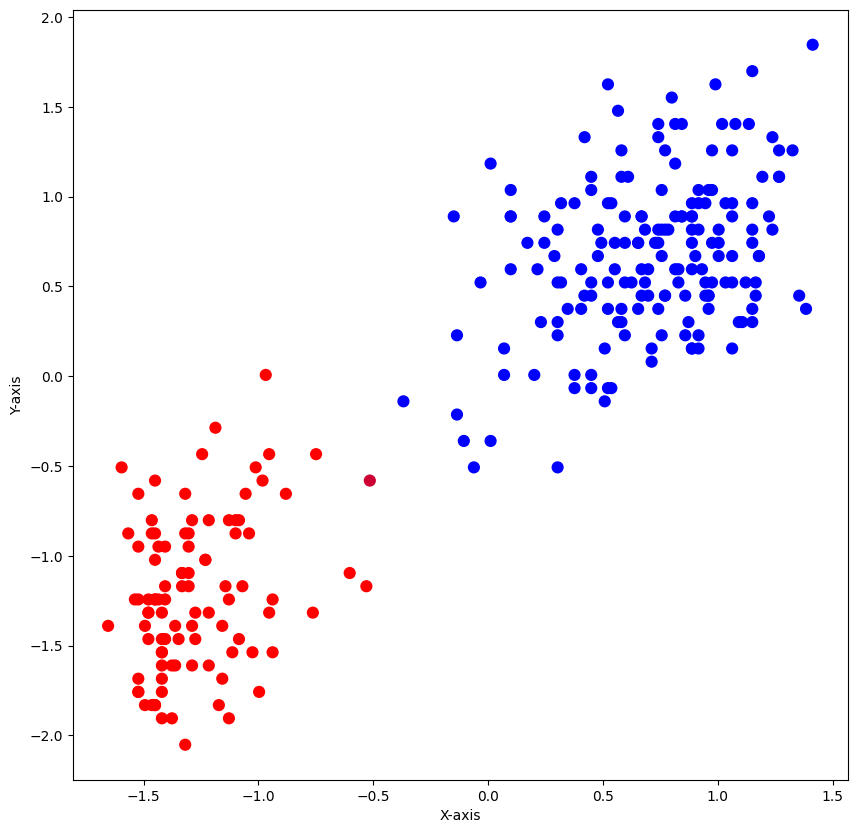

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(df.values[:, 0], df.values[:, 1], c=color_list, s=60)
ax.set_xlabel('X-axis')  # Set the label of the x-axis.
ax.set_ylabel('Y-axis')  # Set the label of the y-axis.
plt.show() # Display


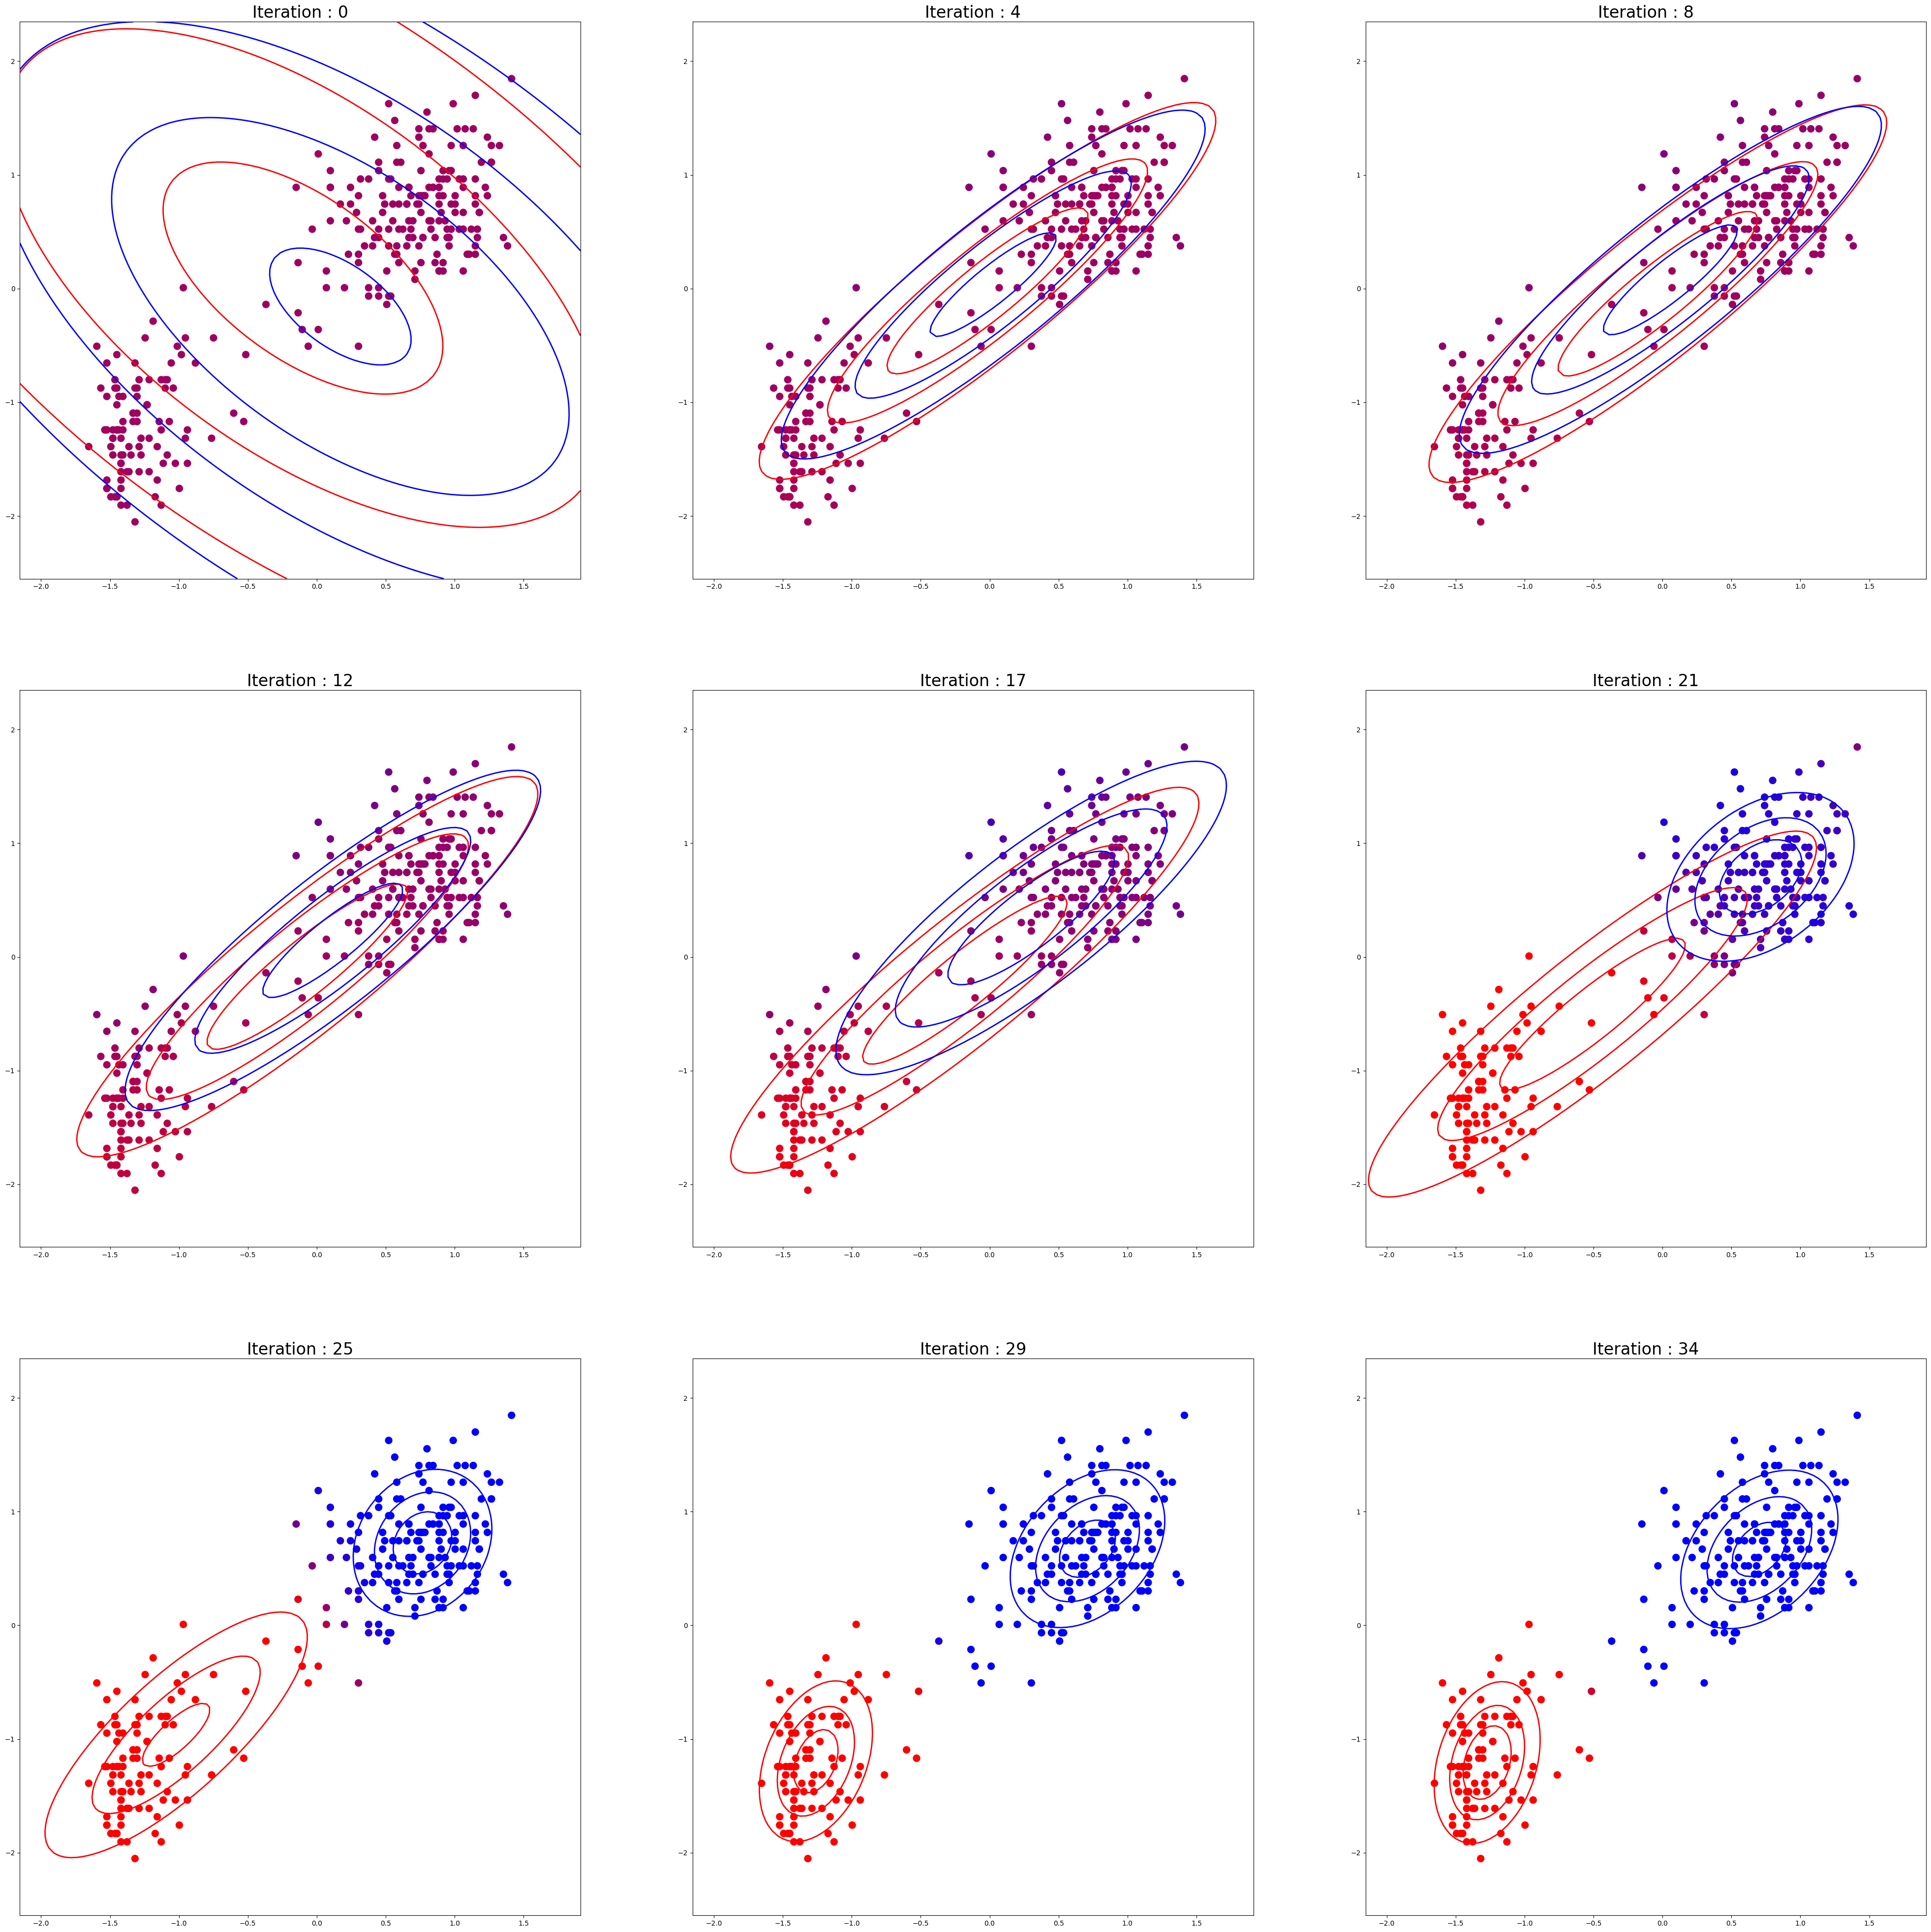

In [15]:
# Get iteration data from the em object
iterations = em.iteration_information
# Select 9 almost equally spaced points from 0 to the number of iterations
iteration_indices = np.linspace(0, len(iterations['log_likelihood']) - 1, 9).astype(int)
# Calculate the number of plots
number_plots = len(iteration_indices)
# Create a figure with 3 rows and 3 columns
fig, ax = plt.subplots(3, 3, figsize=(50, 50))
# Increase the font size of the plot labels
plt.rcParams.update({'font.size': 20})
# Initialize a counter variable to keep track of the current plot number
current_plot_number = 0
# Loop over the selected iteration indices
for iter in iteration_indices:
    mean_list = iterations['means_list'][iter]
    sigma_list = iterations['sigma_list'][iter]
    pi_list = iterations['pi_list'][iter]
    probabilities = np.zeros((df.shape[0], em.K))
    colors = np.zeros((df.shape[0], 3))


    for i in range(df.shape[0]):
        # Calculate the probability of each point belonging to each cluster
        for k in range(em.K):
            probabilities[i, k] = pi_list[k] * \
                em.gaussian_pdf(df.values[i], mean_list[k], sigma_list[k])

        # Normalize the probabilities
        probabilities[i] = probabilities[i] / np.sum(probabilities[i])

        # Set the color of the point based on the probabilities
        colors[i] = np.array([probabilities[i, 0], 0, probabilities[i, 1]])
    
    # Plot the points with colors based on the probabilities
    ax[current_plot_number//3, current_plot_number % 3].scatter(df.values[:, 0],
                                df.values[:, 1], c=colors, s=100)


    x = np.linspace(df.values[:, 0].min() - 0.5,
                    df.values[:, 0].max() + 0.5, 100)
    y = np.linspace(df.values[:, 1].min() - 0.5,
                    df.values[:, 1].max() + 0.5, 100)
    X, Y = np.meshgrid(x, y)

    #****************CONTOUR PLOTS***************#
    
    # Create contour plots of the Gaussian mixture model

    contours = ['red', 'blue']
    for k in range(em.K):

        # Get the mean and covariance matrix for the current cluster
        mu = mean_list[k]
        sigma = sigma_list[k]

        # Evaluate the Gaussian mixture model at each point on the grid
        Z = [em.gaussian_pdf(np.array([x, y]), mu, sigma)*pi_list[k]
             for x, y in zip(np.ravel(X), np.ravel(Y))]
        Z = np.reshape(Z, X.shape)

        # Plot the contour plot for the current cluster
        ax[current_plot_number//3, current_plot_number % 3].contour(X, Y, Z, levels=3,
                                    colors=contours[k], linewidths=[2])

        # Set the title of the plot to indicate the current iteration number
        ax[current_plot_number//3, current_plot_number %
            3].set_title('Iteration : ' + str(iter))

    # Increment the plot counter
    current_plot_number += 1

# Display the contours
plt.show()

### Plot of Log Likelihood V/S Iteration Number

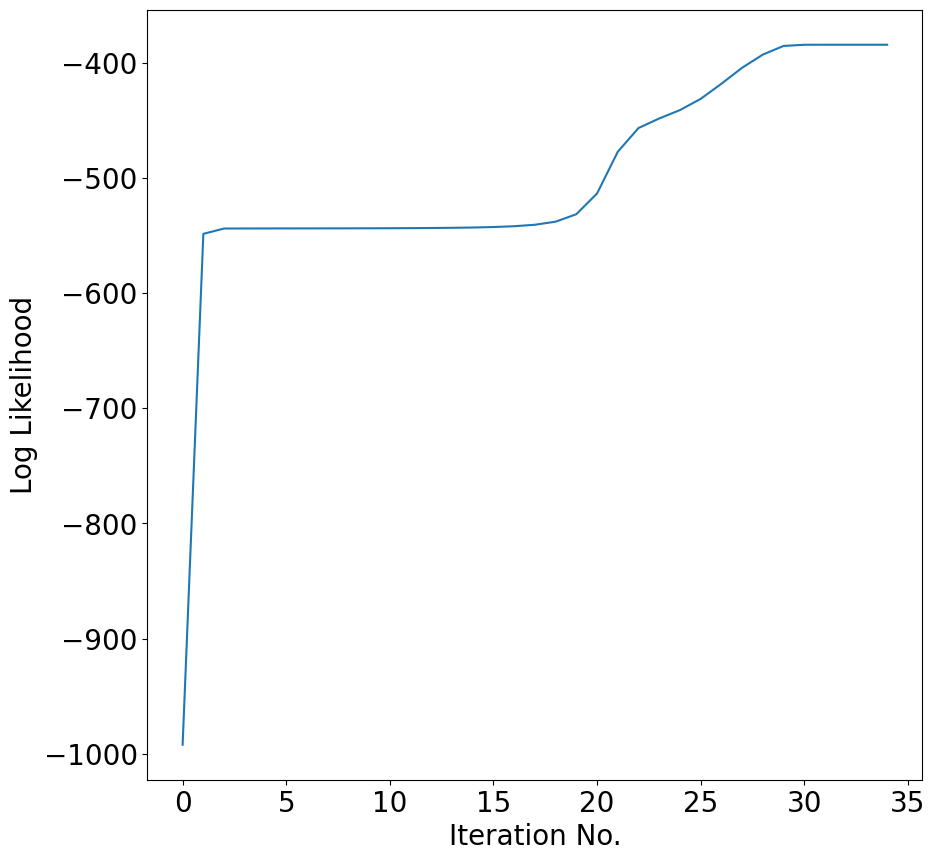

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
# plot the log likelihood data against the iteration number
ax.plot(iterations['log_likelihood'])
# set the x-axis label to "Iteration No."
ax.set_xlabel('Iteration No.')
# set the y-axis label to "Log Likelihood"
ax.set_ylabel('Log Likelihood')
# display the plot
plt.show()


### As we know that the EM Algorithm maximizes the likelihood of the data. Therefore it is clearly obervable from the above plot.